# Plotting GOES-16 AOD data

Yesterday, I was able to set up a conda environment and successfully run some code from from [one of Bryan Blaylock's notebooks][blaylock-notebook-link]. Now lets see if we can plot some AOD data by mimicing his techniques!

## Goal

Pilfer the code from yesterday's notebook (`reproducing_blaylock_2019-04-03`) and modify it to get some of our AOD data plotted.

[blaylock-notebook-link]: https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_TrueColor_Cartopy.ipynb

In [1]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys

Loading the data and retrieving the data and time information should all work the same for our AOD data.

In [2]:
# First, just load the AOD data

BASEPATH = '../../local_data/'
FILE = 'OR_ABI-L2-AODC-M3_G16_s20190781512186_e20190781514559_c20190781516459.nc'

C = xarray.open_dataset(BASEPATH+FILE)

In [3]:
# FROM BLAYLOCK'S NOTEBOOK

######################################################################
# Date and Time Information
# ----------------------------
# Each file represents the data collected during one scan sequence for the
# domain. There are several different time stamps in this file, which are also
# found in the file's name.

# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
# I'm not a fan of numpy datetime, so I convert it to a regular datetime object
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : %s' % scan_start)
print('Scan midpoint : %s' % scan_mid)
print('Scan End      : %s' % scan_end)
print('File Created  : %s' % file_created)
print('Scan Duration : %.2f minutes' % ((scan_end-scan_start).seconds/60))

Scan Start    : 2019-03-19 15:12:18.600000
Scan midpoint : 2019-03-19 15:13:37.200000
Scan End      : 2019-03-19 15:14:55.900000
File Created  : 2019-03-19 15:16:45.900000
Scan Duration : 2.62 minutes


Ok, now this is where we diverge from what Brian Blaylock was doing. Instead of working with 3 different reflectance bands, we should only have to work AOD, so hopefully our process is a bit simpler.

In [4]:
# Get AOD and get a little information about it

AOD = C['AOD'].data

print("AOD is a {}".format(type(AOD)))
print("AOD has shape {}".format(AOD.shape))
print("AOD has a valid range of {}".format(C['AOD'].valid_range))
print("min(AOD) = {}".format(np.nanmin(AOD)))  # ignore NaNs
print("max(AOD) = {}".format(np.nanmax(AOD)))

AOD is a <class 'numpy.ndarray'>
AOD has shape (1500, 2500)
AOD has a valid range of [ 0 -6]
min(AOD) = -0.05000000074505806
max(AOD) = 4.999972820281982


Looks like the shape is exactly what we expect, but there is something funky with our AOD values - our min and max AOD values do not line up with the valid range. Maybe applying the scale_factor and add_offset will put these values in the correct range...

Except that I can't access the scale_factor and add_offset?

In [5]:
# These will produce and error
print(C['AOD'].scale_factor)
print(C['AOD'].add_offset)

AttributeError: 'DataArray' object has no attribute 'scale_factor'

I should be able to access the `scale_factor` and `add_offset` in the same way that I access the `valid_range` (i.e with `C['AOD'].scale_factor`) but I can't. My best guess as to why this is, and why the AOD values are outside the valid range, is that the valid range applies to the AOD values before the scale factor and offset are applied, and `xarray` is automatically applying them under the hood. 

To be investigated further...

For now, I will continue on and try and plot the data that we do have.

(-0.5, 2499.5, 1499.5, -0.5)

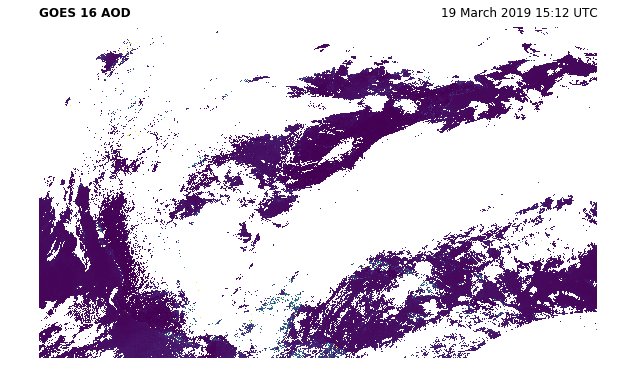

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(AOD)
ax.set_title("GOES 16 AOD", fontweight="semibold", loc="left")
ax.set_title("{}".format(scan_start.strftime("%d %B %Y %H:%M UTC")), loc="right")
ax.axis("off")

That is a plot! Now, lets try and project some political boundaries on top with `cartopy`!

Retrieving the projection information should all work the same as it does in Blaylock's notebook

In [7]:
# FROM BLAYLOCK'S NOTEBOOK

######################################################################
# Plot with `Cartopy`:  Geostationary Projection
# ----------------------------------------------
# 
# The image above is not georeferenced. You can see the land and oceans, but we
# do have enough information to draw state and country boundaries. From the
# GOES-16 file, we can extract all the metadata needed to understand the map
# projection. We will use this data to plot the image on a `Basemap`. The image
# is in a [geostationary
# projection](https://proj4.org/operations/projections/geos.html?highlight=geostationary).

C['goes_imager_projection']

######################################################################
#

# Satellite height
sat_h = C['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C['goes_imager_projection'].sweep_angle_axis

semi_major = C['goes_imager_projection'].semi_major_axis
semi_minor = C['goes_imager_projection'].semi_minor_axis

# The projection x and y coordinates equals the scanning angle (in radians)
# multiplied by the satellite height See details here:
# https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C['x'][:] * sat_h
y = C['y'][:] * sat_h

Plotting code should be similar, but with a few modifications

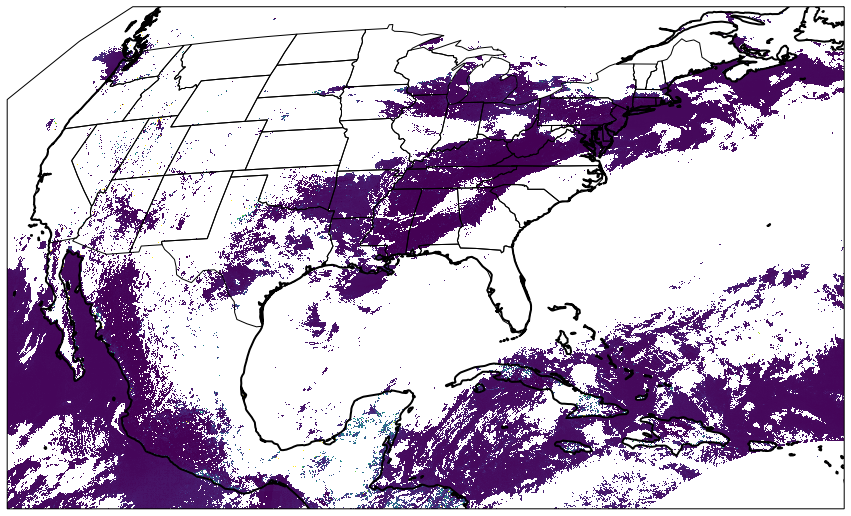

In [10]:
# MODIFIED FROM BLAYLOCK'S NOTEBOOK

######################################################################
# The geostationary projection is the easiest way to plot the image on a
# map. Essentially, we are stretching the image across a map with the same
# projection and dimensions as the data.

fig = plt.figure(figsize=(15, 12))

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
geos = ccrs.Geostationary(central_longitude=sat_lon, 
                         satellite_height=sat_h, globe=globe)

ax = fig.add_subplot(1, 1, 1, projection=geos)

ax.imshow(np.flipud(AOD), origin='lower', 
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos,
          interpolation='nearest')#, vmin=162., vmax=330.)
ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.add_feature(ccrs.cartopy.feature.STATES)

Lets compare this to the screenshot from Panoply that we are trying to emulate.

AOD_in_OR_ABI-L2-AODC-M3_G16_s20190781512186_e20190781514559_c20190781516459.png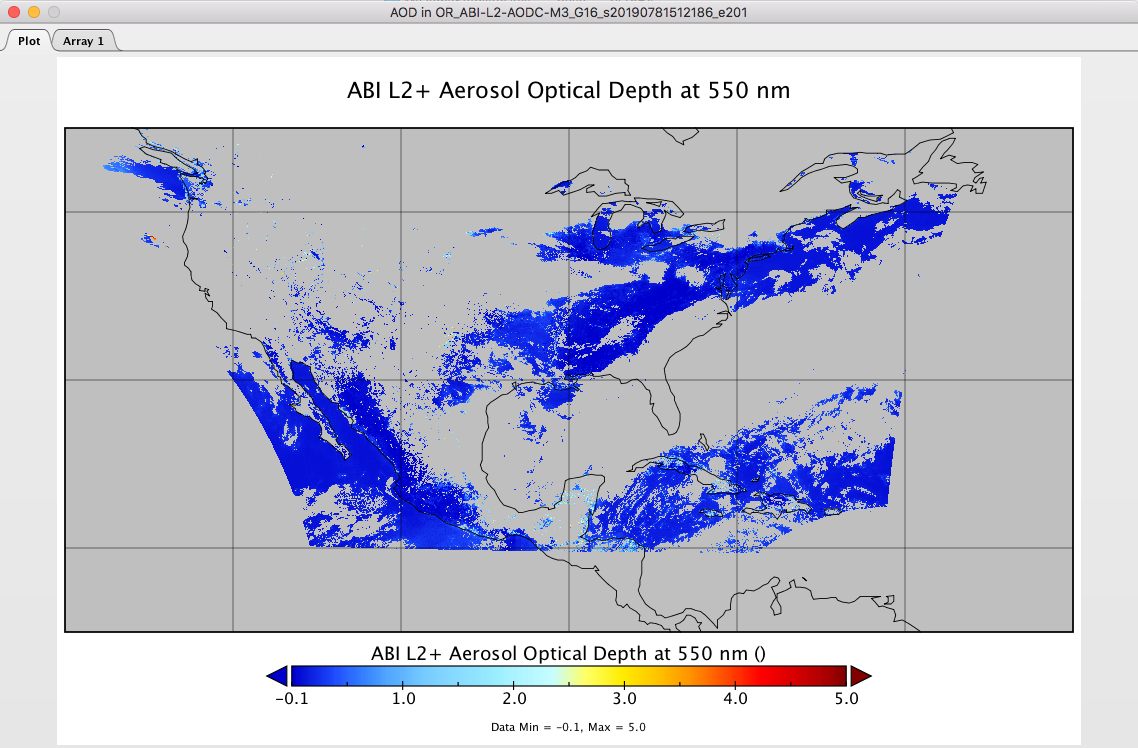

Looks like the two plots match up really well! Also, noticing that Panoply has the same AOD value range as us (min and max are right below the color bar), so thats a good sign!

Now to borrow a bit more of Brian Blaylock's code and reproject the AOD data onto the Lambert Conformal projection

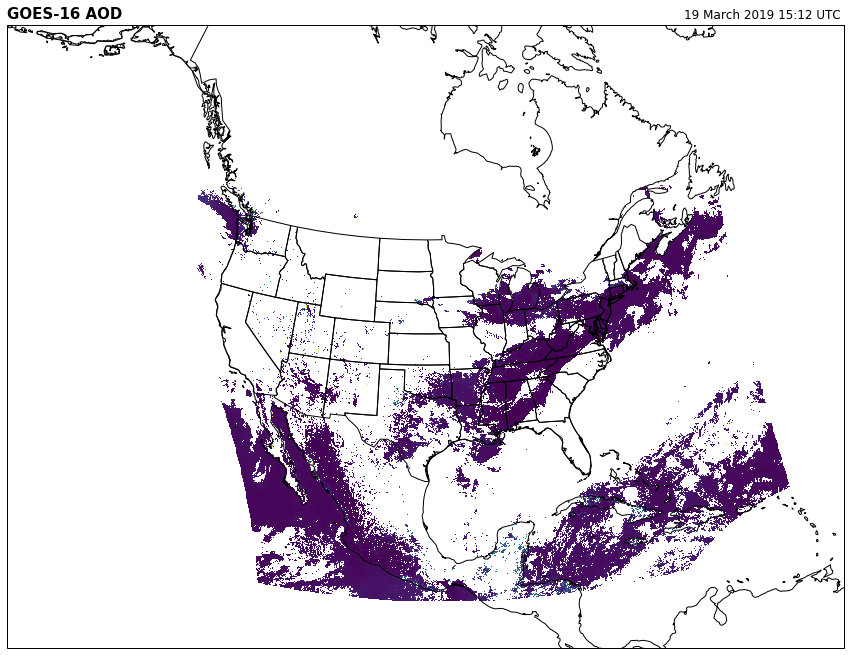

In [11]:
######################################################################
# Using other projections
# ----------------------------------------------
#
# Changing the projections with cartopy is straightforward. Here we use
# the Lambert Conformal projection to display the GOES-16 data.

fig = plt.figure(figsize=(15, 12))

lc = ccrs.LambertConformal(central_longitude=-97.5,standard_parallels=(38.5,38.5))

ax = fig.add_subplot(1, 1, 1, projection=lc)
ax.set_extent([-135, -60, 10, 65], crs=ccrs.PlateCarree())

ax.imshow(np.flipud(AOD), origin='lower',
                   extent=(x.min(), x.max(), y.min(), y.max()),
                   transform=geos,
                   interpolation='none')
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(ccrs.cartopy.feature.STATES)

plt.title('GOES-16 AOD', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');

**Success!**